### Here is contained all data processing code for my master Thesis

## Initial setup

In [1]:
import re,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns
pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'
base_dir=os.path.join("data/transport/safe1000/")
base_save_dir="results/protocols/"
def timespec_difference_without_skew(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff


# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [2]:
# Difference r512c07n01 - r512c06n03 :(6108649, 492739614.0)
# r512c07n01: (7791087, 706014589)
# r512c06n03: (13899737,198754203.0)
# Difference r512c07n01 - r512c06n04 :(6211206, 492739614.0)
# r512c06n04: (14104851,588963442.0)
pub_s = 7791087 
pubns = 706014589
sub_s = 13899737
subns = 198754203

# get difference in timespec
def timespec_difference(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s,subns, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

- boxplot
- metrics in S
- check consistency of all data

## Retrive data

In [3]:
protocols = ["udp", "udpM", "shm", "tcp"] #For now considering only udp

sent_data = defaultdict(list)
sent_data_time= defaultdict(list)
received_data =defaultdict(list)
sent_data_dummy = []
received_data_dummy = []


for prots in protocols:
    # Pub part
    file_path= os.path.join(base_dir,f'pub_{prots}_transportTest_0.data')
    with open(file_path, 'r') as file: 
            for line in file:
                match = re.search(pub_pattern, line)
                if match:
                    cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                    sent_data[prots].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                    s_diff, ns_diff = timespec_difference_without_skew(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                    sent_data_time[prots].append((s_diff, ns_diff))
    # Sub part          
    for j in range(48):
        if prots == "shm" and j == 47: continue
        file_path= os.path.join(base_dir,f'sub_{prots}_transportTest_{j}.data')
        with open(file_path, 'r') as file: 
            for content in file:
                match = re.search(sub_pattern, content)
                if match:
                    index, received_s, received_ns = match.groups()
                    start_s,start_ns = ((sent_data[prots][int(index)][2], sent_data[prots][int(index)][3]))
                    if prots == "shm":s_diff, ns_diff = timespec_difference_without_skew(start_s, start_ns , int(received_s), int(received_ns))
                    else:s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                    received_data[prots].append((s_diff, ns_diff))


## Sending - Receiving

### Clean data

In [4]:
column_time = {}
# Convert data to timespec
for prots in received_data:
    list_difference=[]
    nlen= len(received_data[prots])
    for cycle_data in received_data[prots]:
        list_difference.append(cycle_data[0] * 1e6 + cycle_data[1] / 1e3) # time in second
    column_time[prots]=list_difference
    print(np.average(column_time[prots]))

# Remove outliers
column_time_cleaned = {}
for prots, data in column_time.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_cleaned[prots] = [x for x in data if lower_bound <= x <= upper_bound]

147.79089154166667
60.02507795833333
95.28084700244918
1148.3468615381353


### Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1300x600 with 0 Axes>

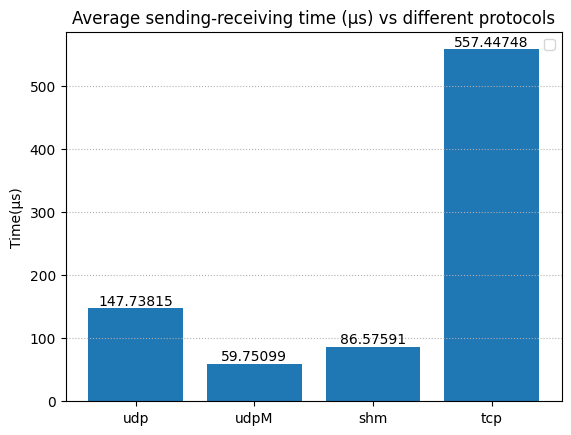

In [5]:
# Prepare data for bar plot
column_averages={}
for prots, data in column_time_cleaned.items():
    column_averages[prots] = np.average(column_time_cleaned[prots])

bar_labels = protocols
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

plt.figure(figsize=(13, 6))
fig, ax = plt.subplots()
bars= ax.bar(bar_labels,column_averages.values())
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.ylabel("Time(μs)")
plt.legend()
plt.title("Average sending-receiving time (μs) vs different protocols")
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir}barplots_sendingreceiving_{base_dir.split('/')[2]}.png")

plt.show()

### Box Plot

maxlenght is 47992
Fixing dimension of :  udpM 47915 47992
Fixing dimension of :  shm 46767 47992
Fixing dimension of :  tcp 45592 47992
dict_keys(['udp', 'udpM', 'shm', 'tcp'])
data


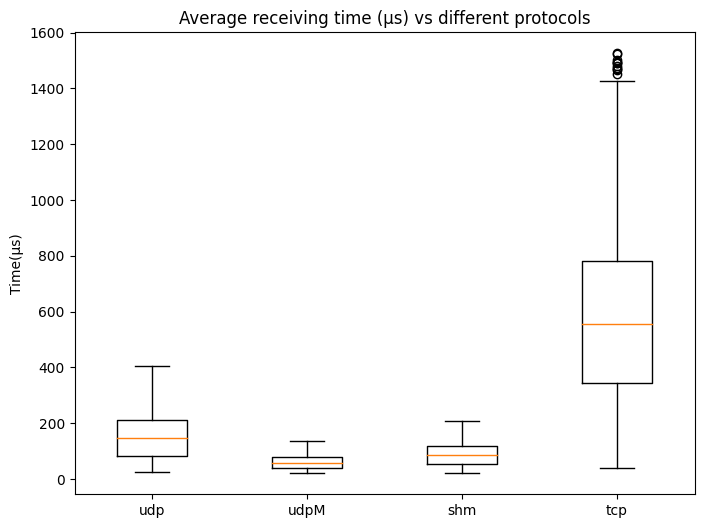

In [6]:
maxlenght = max(len(data) for data in column_time_cleaned.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time_cleaned.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time_cleaned[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time_cleaned.values(),data=column_time_cleaned.keys(),labels=protocols)
plt.title("Average receiving time (μs) vs different protocols")
plt.ylabel("Time(μs)")

print(column_time_cleaned.keys())

print(base_dir.split('/')[0])
plt.savefig(f"{base_save_dir}boxplot_protocols_{base_dir.split('/')[2]}.png")

plt.show()



## Only sending

### Clean data

In [7]:
column_time_sent = {}
# Convert data to timespec
for prots in sent_data_time:
    list_difference=[]
    nlen= len(sent_data_time[prots])
    for cycle_data in sent_data_time[prots]:
        list_difference.append(cycle_data[0] * 1e6 + cycle_data[1] / 1e3) # time in second
    column_time_sent[prots]=list_difference
    print(np.average(column_time_sent[prots]))

# Remove outliers
column_time_sent_cleaned = {}
for prots, data in column_time_sent.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_sent_cleaned[prots] = [x for x in data if lower_bound <= x <= upper_bound]

282.140107
23.024746
153.31062100000003
1000.564821


<Figure size 1000x600 with 0 Axes>

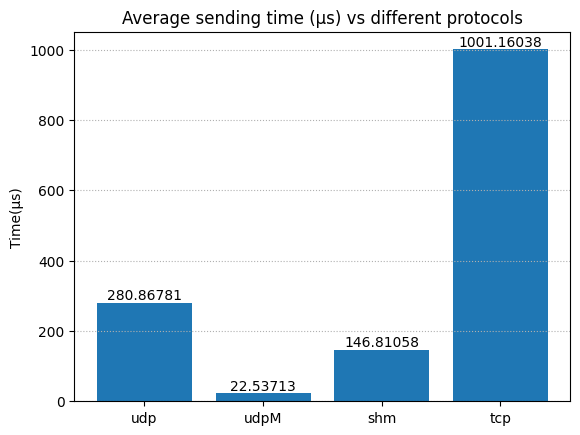

In [8]:
# Prepare data for bar plot
column_averages={}
for prots, data in column_time_sent_cleaned.items():
    column_averages[prots] = np.average(column_time_sent_cleaned[prots])

bar_labels = protocols
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars= ax.bar(bar_labels,column_averages.values())
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.ylabel("Time(μs)")
plt.title("Average sending time (μs) vs different protocols")
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir}barplots_onlysending_{base_dir.split('/')[2]}.png")

plt.show()

## Instruction vs TSC

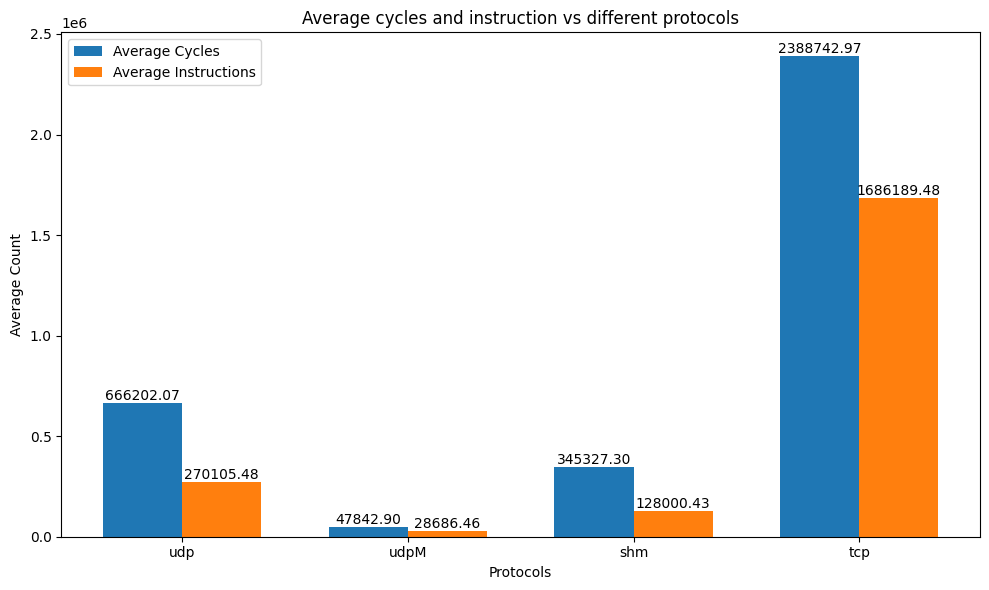

In [9]:
cycles,cycles_cleaned,instructions_cleaned={},{},{}
instructions={}
average_cycles={}
average_instructions={}
for prot in protocols:
    cycles[prot] = [data[0] for data in sent_data[prot]]
    instructions[prot] = [data[1] for data in sent_data[prot]]
    lower_bound, upper_bound = calculate_iqr(cycles[prot])
    cycles_cleaned[prot] = [x for x in cycles[prot] if lower_bound <= x <= upper_bound]
    lower_bound, upper_bound = calculate_iqr(instructions[prot])
    instructions_cleaned[prot] = [x for x in instructions[prot] if lower_bound <= x <= upper_bound]
    average_cycles[prot] = sum(cycles_cleaned[prot]) / len(cycles_cleaned[prot])
    average_instructions[prot] = sum(instructions_cleaned[prot]) / len(instructions_cleaned[prot])

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(protocols))
barsc = plt.bar(x, average_cycles.values(), width=bar_width, label='Average Cycles')
barsi=plt.bar([i + bar_width for i in x], average_instructions.values(), width=bar_width, label='Average Instructions')
plt.xticks([i + bar_width / 2 for i in x], protocols)
plt.xlabel('Protocols')
plt.ylabel('Average Count')
for bar in barsc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in barsi:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title("Average cycles and instruction vs different protocols")
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_save_dir}barplots_cyclesinstruction_{base_dir.split('/')[2]}.png")

plt.show()

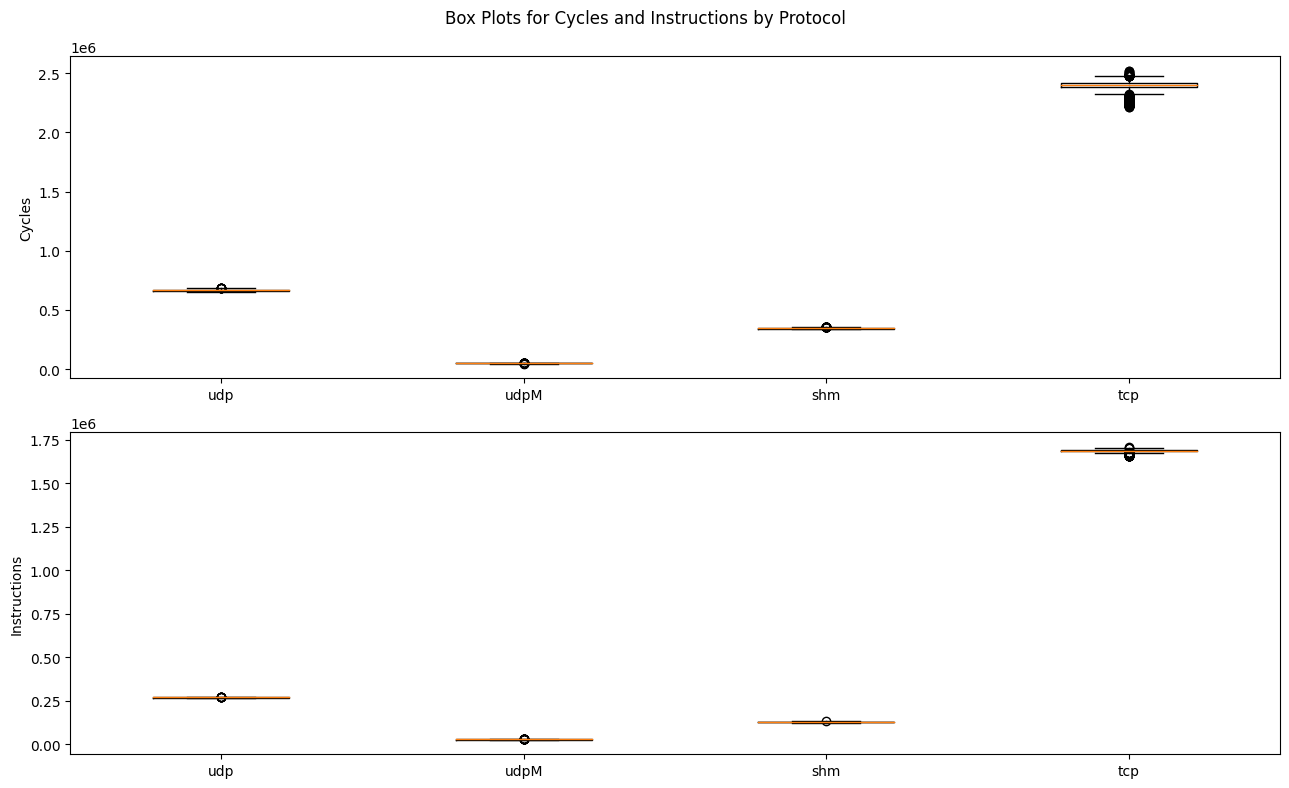

In [10]:
fig, axs = plt.subplots(2, figsize=(13, 8))
fig.suptitle('Box Plots for Cycles and Instructions by Protocol')

# Box plot for cycles
axs[0].boxplot(cycles_cleaned.values())
axs[0].set_xticklabels(cycles_cleaned.keys())
axs[0].set_ylabel('Cycles')

# Box plot for instructions
axs[1].boxplot(instructions_cleaned.values())
axs[1].set_xticklabels(instructions_cleaned.keys())
axs[1].set_ylabel('Instructions')

plt.tight_layout()
plt.show()
